# Gradient Boosting

The next classification model we will investigate is the Gradient Boosting Classifier.

## Importing the libraries

In [87]:
import sys 
sys.path.append('..')

In [88]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For creating the model
from sklearn.ensemble import GradientBoostingClassifier

#For evaluating the model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from helper_fun import * #Imports Balanced MCC formula

## Importing data

In [89]:
import pickle

#Loading the training and test splits from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

In [90]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

In [91]:
#Verifying the previous step has been done correctly.
split_data.keys()

dict_keys(['random', 'stratified', 'undersample', 'oversample'])

## Initial Model

Here, we'll create an initial classification model using the GradientBoostingClassifier function from scikit-learn and test it on our splits. We will use the default parameters but set the random seed to 0 to allow for effective and relevant comparison later on.

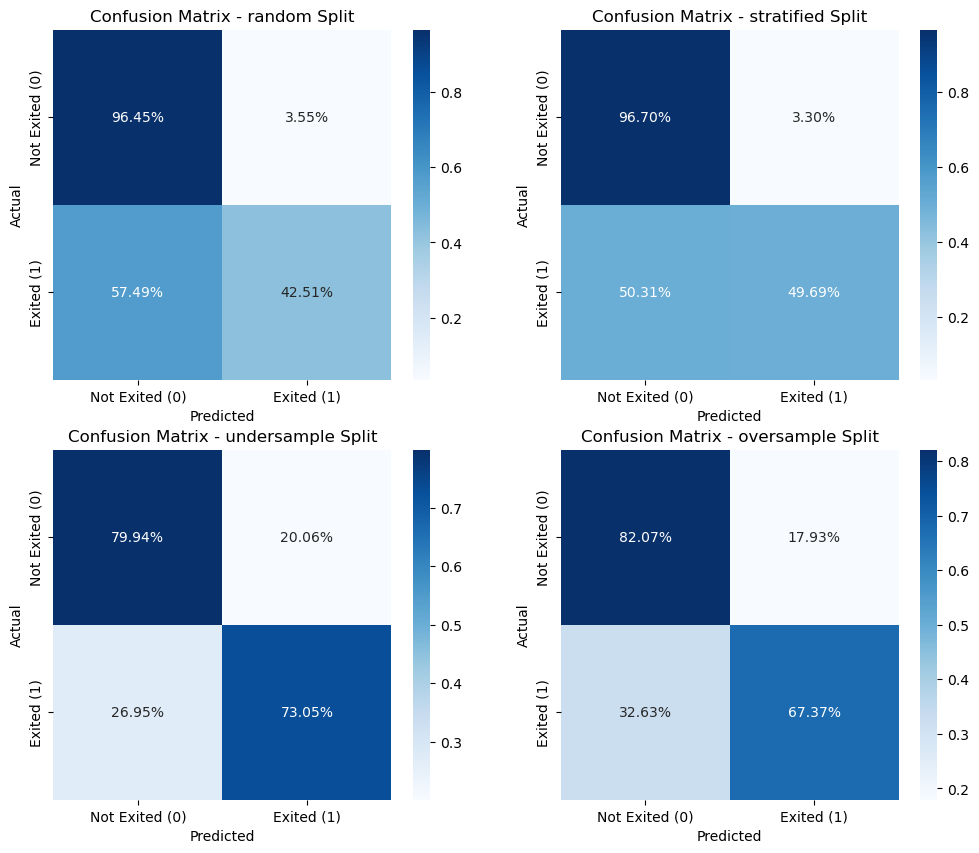

<Figure size 800x600 with 0 Axes>

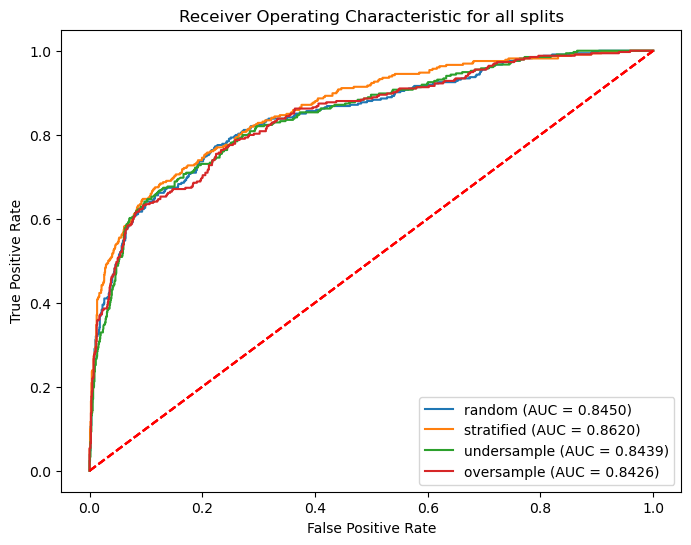

In [92]:
#Creating the model

model = GradientBoostingClassifier(random_state=0)

#Create somewhere to store the performance metrics
performance ={}

#Creating function in order to evaluate our model more easily
def evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance):

    #Creating 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))

    #ROC Curve Figure
    plt.figure(figsize=(8,6))

    #Fit model for each of the 4 splits
    for idx, split in enumerate(split_data):

        X_train, X_val, y_train, y_val =split_data[split]
    
        #Train model
        model.fit(X_train, y_train)

        y_score = model.predict_proba(X_val)[:, 1]
    
        #Predict on validation set
        y_val_pred = model.predict(X_val)

        #Get general classification report
        test_report = classification_report(y_val, y_val_pred, output_dict = True)

        #Recall, F1-score, and Balanced MCC for class 1 (positive class)
        recall = test_report['1']['recall']
        f1_score = test_report['1']['f1-score']
        balanced_MCC = balanced_MCC_macro_avg(y_val, y_val_pred)
        
        #Define ourperformance metrics
        performance_matrix[split] = {
            'recall': recall,
            'f1 score': f1_score,
            'balanced MCC': balanced_MCC
        }

        #Plot confusion matrix for test set
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        #Normalize the confusion matrix by the number of true samples per class to get the values of the confusion matrix as a percentage of the total and labelling
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[idx].set_title(f'Confusion Matrix - {split} Split')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xlabel('Predicted')

    
        #Plot ROC curve on the same figure for all splits
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = roc_auc_score(y_val, y_score)
        plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for all splits')
        plt.legend(loc="lower right")

        #Get general classification report
        test_report = classification_report(y_val, y_val_pred, output_dict = True)

        #Recall, F1-score, and Balanced MCC for class 1 (positive class)
        recall = test_report['1']['recall']
        f1_score = test_report['1']['f1-score']
        balanced_MCC = balanced_MCC_macro_avg(y_val, y_val_pred)
        
        #Define ourperformance metrics
        performance_matrix[split] = {
            'recall': recall,
            'f1 score': f1_score,
            'balanced MCC': balanced_MCC
        }

    #Show the plots
    return performance_matrix  


#Running model
performance = evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance)
    

In [93]:
#Creating table to see our performance metrics on each split
performance_df = pd.DataFrame(performance).T
performance_df

,recall,f1 score,balanced MCC
random,0.425150,0.545106,0.462653
stratified,0.496933,0.611321,0.525673
undersample,0.730539,0.586538,0.531167
oversample,0.673653,0.572519,0.499780


We can see from the ROC curve that the model performs well on all splits.

In the context of our problem, we're interested in getting a high Recall value from our models, since we want to make sure we identify the customers who are going to churn so that the bank can put retention methods in place. 

The effects of the imbalanced dataset can be seen when it comes to the Recall of the random and stratified splits. In both these cases, the make-up of the data in the validation and test sets is expected to be very similar to that of the full dataset. Therefore, when training our model it doesn't have much information to go off when it comes to the predicting those who will churn, since a significantly smaller number of those in our data do churn.

On the contrary, oversampling and undersampling generate balanced test sets and assist model performance leading to the improved performance we can see above. The Recall value in undersampling and oversampling are of a satisfactory level for an initial attempt. This is to be expected due to the nature of the dataset we're considering as it is imbalanced and the over/undersampling accounts for this.

In terms of the f1-score and balanced MCC, the values for all splits are pretty similar. This suggests that across the board the precision and recall balance out for this model, again, we sort of expect this since despite the random and stratified splits having lower recall, they will identify the cases where people don't churn much better as they have been trained on a large amount of this data in comparison to the oversample and undersample splits. This is visible in the top left of the confusion matrix.

Already, our model is vastly outperforming the baseline model on all fronts.

In the following, we'll attempt to refine and improve the model by adjusting the parameters.

## Parameter Tuning

Our next step is finding what parameters work best for this model, in the previous section we just left everything as the default but we'll now use a grid search with cross-validation in order to find what set of parameters gives our model the optimum performance on the data we have at hand

We'll start by seeing what parameters are currently at play in our model.

In [94]:
#Look at the parameters used by our gradient boosting classifier
print('Parameters currently in use:\n')
model.get_params()

Parameters currently in use:



{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

The most important features for us are the learning rate, the number of trees being used, and the depth of these trees. Hence, we'll tune hese three parameters and attempt to find the best combination.

For learning rate, values in the neighbourhood of 0.1 will be of most use. A lower learning rate give rise to a more robust model that is less likely to overfit, therefore improving the models performance on unseen data and making it more generalisable.

When it comes to the number of trees that will be used to generate the final model, or n_estimators, we have a bit more room to play around. Generally, at a high number of trees the model remains robust. 

max_depth is used to control the complexity of each tree that is to be used in this ensemble method. The default value is 3 and a max_depth in and around this value will be useful for us, again to help avoid overfitting and improve the robustness of the model.

We'll begin by finding what the ideal values for the learning_rate and n_estimators. These two parameters are inversely correlated so its in our interest to tune these first.

We have opted to use a two-phase grid search to find the best hyperparameters primarily for computational purposes. Previously, all 3 parameters we're looking at tuning were being tested at the same time across a wider range of values, however this proved to be very inefficient. Therefore, we will do it as a two-step process with a smaller amount of values than was considered before, but that still cover a large range of values.

Randomised Search would be pointless here as not that many iterations are being tested.

In [95]:
#Import Grid Search function
from sklearn.model_selection import GridSearchCV

#We'll use the f1-scorer since we want a low number of false negatives but also want to manage the number of false positives and keep it fairly low.
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score)

#Creating paramter grid for the grid search cross-validation to test on
param_grid = {
    'n_estimators': [100, 500, 1000, 1750],
    'learning_rate': [0.01, 0.1, 0.2],
}

#Running paramter tuning
grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, n_jobs = -1)
grid_search.fit(X_train_raw, y_train_raw)

print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 1750}


The Grid Search Cross-Validation has given us values of: learning_rate = 0.01, n_estimators = 1750. A low learning rate helps prevents overfitting as it reduces the contribution of each tree. The high number of trees that are going to be at play in our new model may be a cause for concern when it comes to how quickly the model runs, but hopefully with methods we are going to employ further down the line this shouldn't be a major issue. 

The learning_rate and n_estimators working in tandem is evidenced here as we now have a lower learning rate and higher amount of trees. Ideally, this should prevent overfitting by giving trees less influence and increasing the amount of them that there are.

We'll now investigate what the depth of each tree should be below.

In [96]:
#Create paramter grid just for the max_depth
param_grid2 = {
    'max_depth' : [2,4,6,8]
}

#Create model using optimal values given by previous part
grid_model = GradientBoostingClassifier(n_estimators = 1750, learning_rate = 0.01, random_state = 0)

#Running paramter tuning
grid_search = GridSearchCV(grid_model, param_grid2, cv=5, scoring=f1_scorer, n_jobs = -1)
grid_search.fit(X_train_raw, y_train_raw)

print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 4}


This randomised search gives values of: n_estimators = 1750, max_depth = 4 and learning_rate = 0.01.

We will now run a new model with our parameters and generate the same figures and values as before to see if this has improved our model.

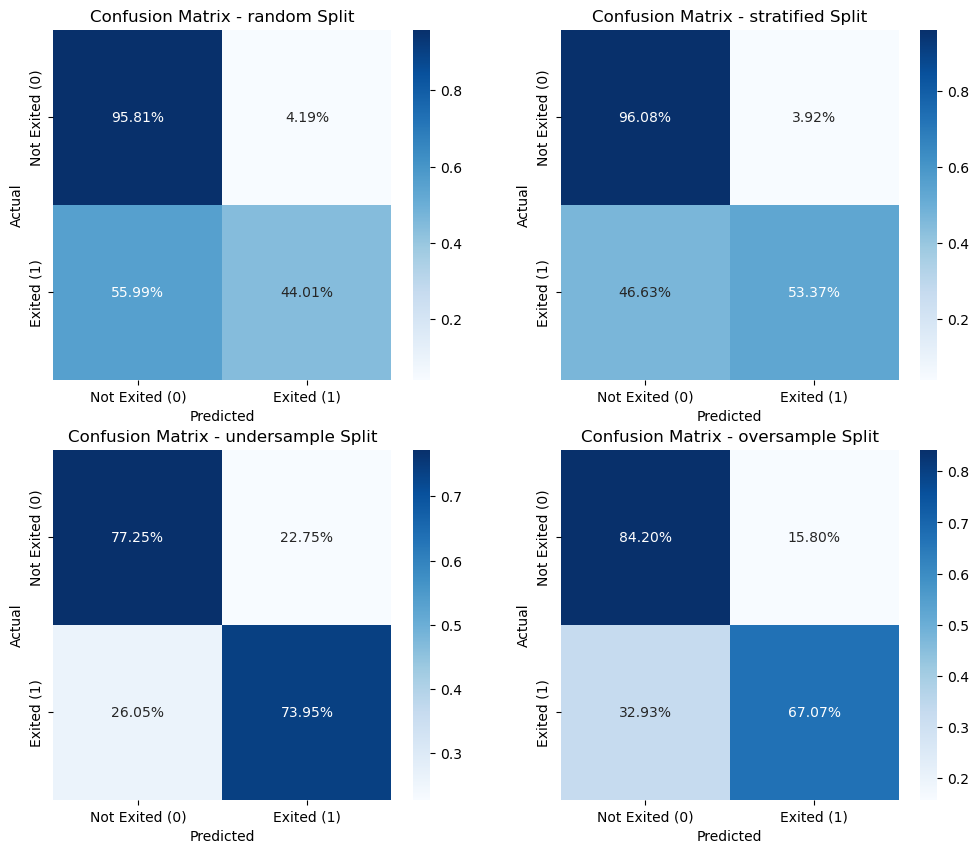

<Figure size 800x600 with 0 Axes>

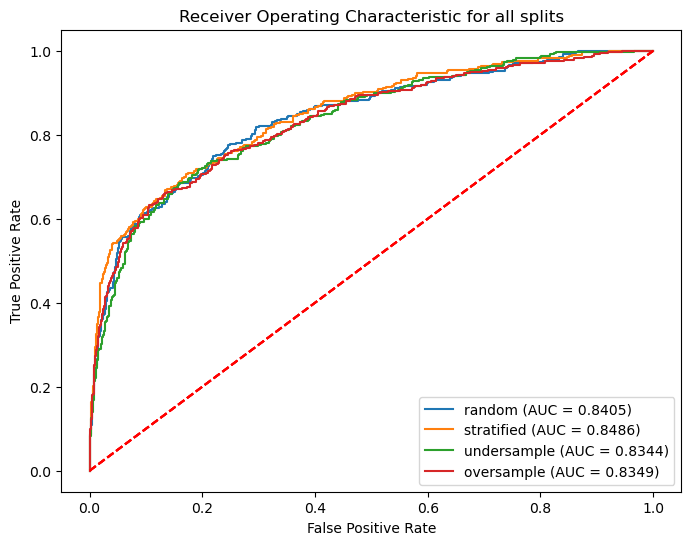

In [97]:
#Creating grid with our optimal parameters
improved_params = {'n_estimators': 1750, 
                   'learning_rate': 0.01, 
                   'max_depth': 4
                   }

#Creating model
improved_model = GradientBoostingClassifier(**improved_params, random_state=0)

#Running model
performance_improved = {}
performance_improved = evaluating_performance_diff_splits(model=improved_model,split_data=split_data,performance_matrix=performance_improved)


In [98]:
#Visualising performance metrics
improved_performance_df = pd.DataFrame(performance_improved).T
improved_performance_df

,recall,f1 score,balanced MCC
random,0.440120,0.550562,0.465594
stratified,0.533742,0.632727,0.546860
undersample,0.739521,0.568470,0.512312
oversample,0.670659,0.591029,0.520378


## Comparison to initial model

We'll now take a look at the breakdown of our two different models performance on our chosen metrics and assess whether the hyperparameter tuning we have carried out has in fact improved our model.

In [99]:
performance_df

,recall,f1 score,balanced MCC
random,0.425150,0.545106,0.462653
stratified,0.496933,0.611321,0.525673
undersample,0.730539,0.586538,0.531167
oversample,0.673653,0.572519,0.499780


In [100]:
improved_performance_df

,recall,f1 score,balanced MCC
random,0.440120,0.550562,0.465594
stratified,0.533742,0.632727,0.546860
undersample,0.739521,0.568470,0.512312
oversample,0.670659,0.591029,0.520378


We'll start by looking at the balanced MCC. Across all splits, the change in the value is fairly small, but for 3 of the splits (random, stratified, oversample) it's at least going in the right direction which suggests an improvement in our model.


As we can see above, in terms of recall we can see a healthy improvement on the random and stratified splits.
A slight improvement can be seen in the split in which our model was already performing best, the undersampled split, with the recall value creeping closer to 0.74. 
The recall value associated with the oversampled split has stayed more or less the same, although there is a negligible decrease.
On the whole, everything is going in the right direction after the hyperparameter tuning with regards to the recall score across all splits.

Although the recall is our primary focus, we're also interested in the f1-score, as we want to be able to put in measures to retain our customers without wasting resources trying to keep those who will likely stay anyway.
Similarly to the recall score, the f1-score of the random and stratified split, which due to the imbalanced nature of our dataset are our least favourable splits, has improved slightly.
In contrast to the change in recall score for the undersample split, the f1-score for the undersample split has decreased, suggesting that the changes we've made to our model for this split is generally predicting more people to churn than previously.
For the oversample split our f1-score has improved.
Again, on the whole this is good news and the change in parameters has aided us in creating a more robust and accurate model.

Although we are generally seeing an uptick in the recall and f1-scores across all splits, this isn't the only thing we have to consider when building this model. The methods which we used to arrive at these improved parameters and the nature of these new parameters has proved quite computationally taxing. The general trend in results is a positive one but it might be worth considering if this slight albeit successful process is worth it when we take into account the efficiency and complexity of both the methods used and the new parameters as the new model takes noticeably longer to run.

## Early Stopping

One way we can reduce the computational complexity, whilst simultaneously assisting in preventing the overfitting problem and making the model more generalisable is through early stopping. This enables us to find the optimal number of iterations required in order to give us the most benefit in these regards. 

Early stopping works by stopping the training process when the improvements we are seeing between different models becomes very small. In this way, the model doesn't run fully to completion as it would without it and we also don't generate a model that is too specific to the data we're training it on as a normal gradient boosting classifier might. This will make our model more generalisable and useful on previously unseen data, such as the test data we'll look at later.

For this we'll use the improved model we have just generated previously, hopefully this will help the computational problems we had previously.

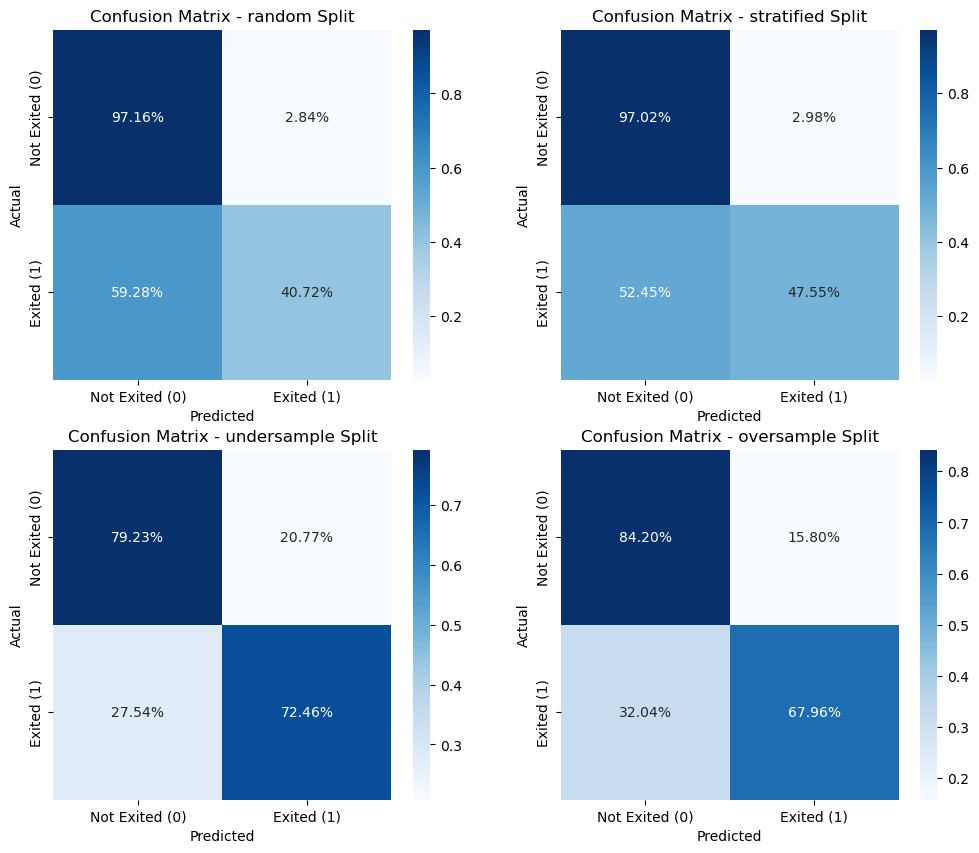

<Figure size 800x600 with 0 Axes>

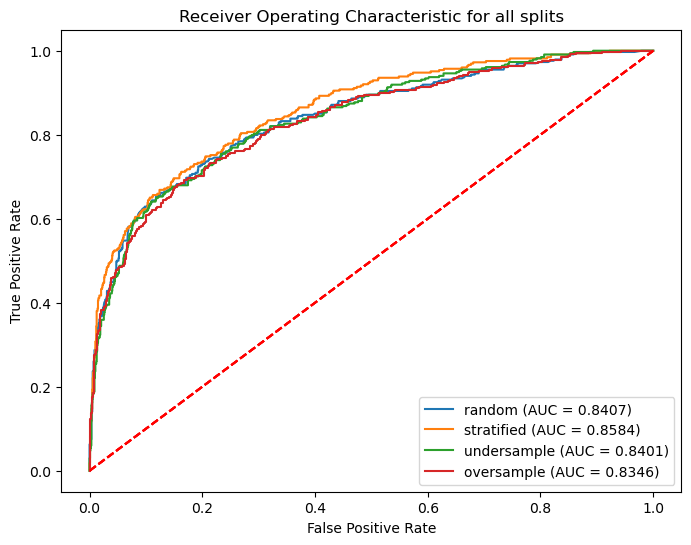

In [101]:
#Creating new model, making use of early stopping
es_model = GradientBoostingClassifier(**improved_params, validation_fraction = 0.1, n_iter_no_change=15, random_state = 0)

#Running new model
performance_es = {}

performance_es = evaluating_performance_diff_splits(model=es_model,split_data=split_data,performance_matrix=performance_es)


In [102]:
#Visualising early stopping model
es_performance_df = pd.DataFrame(performance_es).T
es_performance_df

,recall,f1 score,balanced MCC
random,0.407186,0.537549,0.458803
stratified,0.475460,0.597303,0.512778
undersample,0.724551,0.576877,0.517999
oversample,0.679641,0.596583,0.528679


Aside from the oversampled split, our model has worsened in terms of recall across the other splits. It has slightly improved the f1-score and balanced MCC of the under and oversampled splits which is good news. But, again, it has worsened when it comes to the random and stratified split. However, moving forward we will use the model that early stopping has given us since the change in performance is minimal and the speed at which the model runs has improved. Additionally, in theory, early stopping has prevented the model from learning about irrelevant patterns in the data that are too specific to the training set by stopping when improvements are minimal, and will therefore be beneficial to us when it comes to assessing this model on the test data.

## Feature Removal

Building on the work we have already done when it comes to overfitting, the removal of certain variables in the data set can help remedy this overfitting and decrease the noise in the dataset, leading to improved performance on test sets, a more robust model, and greater generalisability.

We'll begin by seeing what variables are in the dataset.

In [103]:
X_train, X_val, y_train, y_val = split_data['random']

In [104]:
#Seeing what variables are in the dataset
variables=list(X_train.columns)
print(variables)

['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [105]:
#Finding importance value of each variable
es_model.fit(X_train, y_train)
importances = es_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': variables, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,Age,0.390709
3,NumOfProducts,0.299644
7,IsActiveMember,0.118268
9,Geography_Germany,0.061373
2,Balance,0.038645
4,BalanceSalaryRatio,0.032017
6,CreditScoreGivenAge,0.015624
0,CreditScore,0.015110
5,TenureByAge,0.014617
12,Gender_Male,0.007370


We can see that at a threshold of circa 0.01, gender and Geography_Spain and Geography_France are not important. In the context of our problem and using common sense, although Geography_Germany is above the 0.01 threshold, we will remove this feature to remain consistent with removing the other two geographical variables.

In [106]:
#Make list of what we consider to be 'important' values
important_variables = ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'BalanceSalaryRatio', 'CreditScoreGivenAge', 'CreditScore', 'TenureByAge']

print(important_variables)

['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'BalanceSalaryRatio', 'CreditScoreGivenAge', 'CreditScore', 'TenureByAge']


In [107]:
#Creating a new test and validation set with just the important variables in
important_train_vars = X_train[important_variables]
important_val_vars = X_val[important_variables]

#Checking it has right columns
important_train_vars.columns

Index(['Age', 'NumOfProducts', 'IsActiveMember', 'Balance',
       'BalanceSalaryRatio', 'CreditScoreGivenAge', 'CreditScore',
       'TenureByAge'],
      dtype='object')

Now that we've generated our new datasets with the less important features taken out and verified that the columns are correct, we can test our model on all splits to see how it performs.

In [108]:
for i, split in enumerate(split_data):
    X_train, X_val, y_train, y_val = split_data[split]
    important_train_vars = X_train[important_variables]
    important_val_vars = X_val[important_variables]
    es_model.fit(important_train_vars, y_train)
    predictions = es_model.predict(important_val_vars)
    report = classification_report(y_val,predictions,output_dict=True)
    print(report['1'])

{'precision': 0.79375, 'recall': 0.38023952095808383, 'f1-score': 0.5141700404858299, 'support': 334.0}
{'precision': 0.774869109947644, 'recall': 0.4539877300613497, 'f1-score': 0.5725338491295938, 'support': 326.0}
{'precision': 0.4607645875251509, 'recall': 0.6856287425149701, 'f1-score': 0.5511432009626955, 'support': 334.0}
{'precision': 0.48660714285714285, 'recall': 0.6526946107784432, 'f1-score': 0.5575447570332481, 'support': 334.0}


On all splits, the recall and f1-score go down after we have removed the variables we deemed unimportant. This may suggest that those that were taken out do have some predictive power. In the case of Geography_Germany, we may have been a bit arrogant in assuming it wasn't important despite what the importance table tells us, as we just grouped it in with the other Geography variables and removed it.

For the final model, we'll include all of the features to assess our model to ensure maximum performance.

## Final Model

We now have our final model. We'll test this model on our unseen test set and evaluate how our model would fair on a fully unseen dataset and assess its applicability.

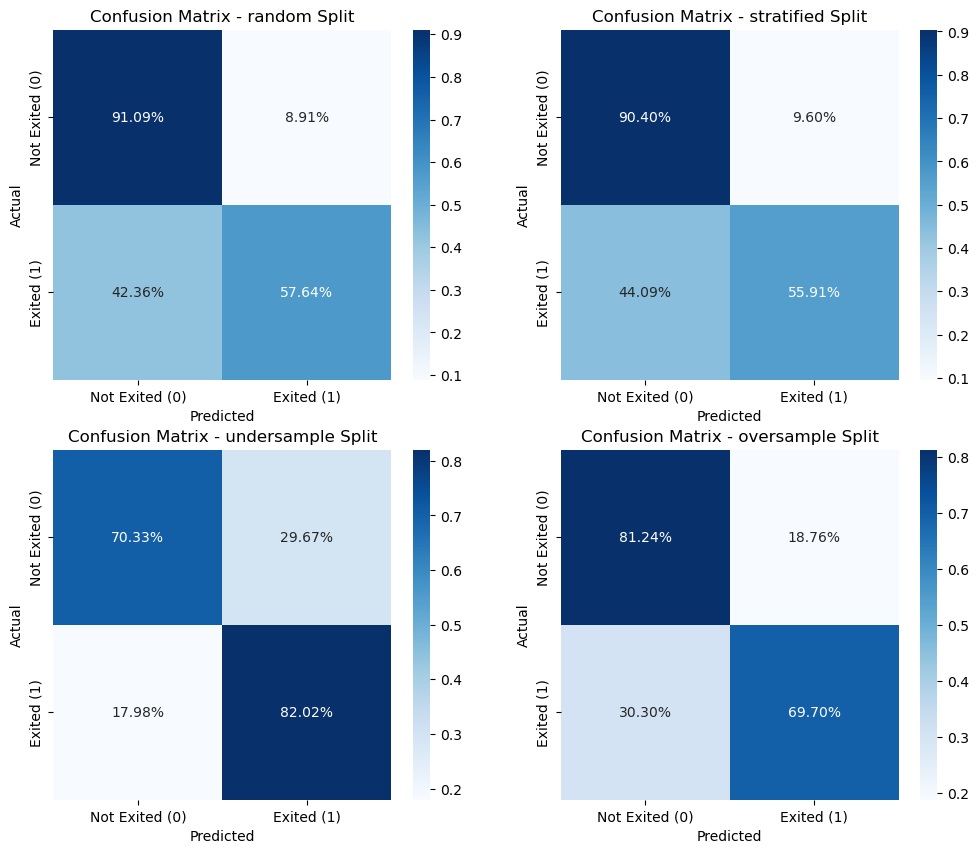

<Figure size 800x600 with 0 Axes>

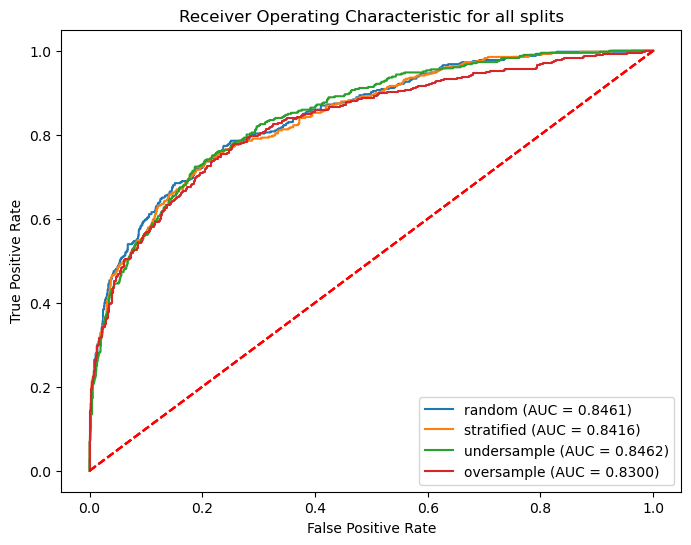

,test_recall_1,test_f1_score_1,balanced_MCC
random,0.576355,0.598465,0.517067
stratified,0.559113,0.577608,0.493404
undersample,0.820197,0.549505,0.527075
oversample,0.697044,0.572874,0.512891


In [109]:
#Create place to store our final performance metrics
final_performance = {}

#Creating 2x2 grid for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
plt.figure(figsize=(8,6))

#ROC Curve Figure
plt.figure(figsize=(8,6))

#Fit model for each of the 4 splits
for idx, split in enumerate(split_data):

    X_train, X_val, y_train, y_val =split_data[split]

    #Train model
    es_model.fit(X_train, y_train)

    y_score = es_model.predict_proba(X_test_raw)[:, 1]
    
    #Predict on validation set
    y_test_pred = es_model.predict(X_test_raw)

    #Plot confusion matrix for test set
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    #Normalize the confusion matrix by the number of true samples per class to get the values of the confusion matrix as a percentage of the total and labelling
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

    
    #Plot ROC curve on the same figure for all splits
    fpr, tpr, _ = roc_curve(y_test_raw, y_score)
    roc_auc = roc_auc_score(y_test_raw, y_score)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for all splits')
    plt.legend(loc="lower right")#

    #Get general classification report
    test_report = classification_report(y_test_raw, y_test_pred, output_dict = True)

    #Recall, F1-score, and Balanced MCC for class 1 (positive class)
    recall = test_report['1']['recall']
    f1_score = test_report['1']['f1-score']
    balanced_MCC = balanced_MCC_macro_avg(y_test_raw, y_test_pred)
        
    #Define performance metrics
    final_performance[split] = {
        'test_recall_1': recall,
        'test_f1_score_1': f1_score,
        'balanced_MCC' : balanced_MCC
    }

#Show the plots
plt.show()

#Show performance metric figures
final_performance_df = pd.DataFrame(final_performance).T
final_performance_df

On our test data, our Gradient Boosting Classifier model has performed exceptionally with regards to the recall value when compared to the other models, achieving a recall value of over 0.8 on the undersample split. This means that we identify the large majority of those that will churn, our main aim when it comes to this dataset and the real-world implications of the use of this model. We can see that our performance metrics that are of secondary importance (f1-score and balanced MCC) have decreased, we would need more contextual information on the cost effect that implementing customer-retention tactics would have to see how significant this is. If it would be more costly to try and retain the customers that would stay anyway than it would to let a few more customers go by implementing a different model and failing to identify these customers then the high recall value might not be worth it. However this would be complex. Customer satisfaction may be improved by the retention tactics leading to a reduction in churning long term and a better reputation for the bank, making them more attractive in the public eye and drawing more customers to the bank.

## Conclusion

The Gradient Boosting Classifiers strength lies in how to builds up from the weaker learners and attempts to correct the errors that hold back the earlier fitted models. Naturally, we'd assume that this grants it greater predictive power in comparison to its close relative the random forest, and for what we're looking for, this is what we see. Not only has it vastly outperformed the understandably weak baseline logistic regressor, but it has also seen slight improvements over the random forest when it comes to the recall.

The use of hyperparameter tuning and early stopping has helped improve our model from the initial one on two fronts. Hyperparameterisation has helped make our strengths stronger, and early stopping has assisted in making our weaknesses weaker. The improved paramters we found from the tuning led to an improvement in our predictive power whilst the early boosting meant that our new and improved model was more robust and able to be used on unseen datasets, as is demonstrated in the previous section.

Despite this, its important we look at where our model suffers. Due to the sequential nature of the Gradient Boosting Classifier and the broad range of values that needed to be tested in order to get the most out of it, the grid search cross validation to improve our parameters took a staggering amount of time. Hyperparamter tuning led us to looking at models that involved a very large amount of trees of significant depth at a very slow learning rate, making the process slow and computationally expensive. This improved model was then defined by parameters that meant it took a longer than usual time, namely the high amount of trees being used and the low learning rate. This afforded us many advantages in the quality of our model but also made the process a lot longer and more taxing. The knock-on effect this had when it came to trying to refine this improved model meant that all further steps were very long and may not be worth it. We made an effort to remedy this with the early stopping, but whilst this helped, the model was still significantly longer than we might prefer.

As has been mentioned several times before, overfitting is also a risk. During the learning process gradient boosting classifiers tend to overfit to the noise in the training data, seeing patterns where there are none and therefore making them weak when used on other data. However, due to how we approached this problem and the methods employed to generate the final model, I believe we have mitigated this successfully, as is demonstrated by the strong performance on the final test.

All in all, this model has been successfully crafted and trained in order to perform strongly and robustly when it comes to identifying customers who have churned. It's performed well on all metrics, especially recall, when compared to the other models we have considered in this project.

## References

https://medium.com/@datasciencewizards/understanding-the-gradient-boosting-algorithm-9fe698a352ad

https://www.digitalocean.com/community/tutorials/gradient-boosting-for-classification

https://www.datacareer.de/blog/parameter-tuning-in-gradient-boosting-gbm/#:~:text=Most%20data%20scientist%20see%20number,evaluate%20models%20based%20on%20accuracy.

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://scikit-learn.org/1.5/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html

https://medium.com/@juanc.olamendy/understanding-early-stopping-a-key-to-preventing-overfitting-in-machine-learning-17554fc321ff

AI was used for portions of the code.